<a href="https://colab.research.google.com/github/DrumDong/Donggyu/blob/master/Car_MPG_Prediction_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 자동차 연비 예측하기

회귀란 무엇인가?

회귀(regression)는 가격이나 확률 같이 연속된 출력 값을 예측하는 것이 목적입니다. 이와는 달리 분류(classification)는 여러개의 클래스 중 하나의 클래스를 선택하는 것이 목적입니다(예를 들어, 사진에 사과 또는 오렌지가 포함되어 있을 때 어떤 과일인지 인식하는 것). 

** Reference from TensorFlow guide **

## Data download and Data check

In [0]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [83]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'/root/.keras/datasets/auto-mpg.data'

---------------

판다스를 활용해서 데이터 셋을 불러오자.
- pd.read_csv(데이터셋,names = 각각 컬럼에 들어올 컬럼 명, na_values = null 값 표기, sep= 구분자)

In [84]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


데이터셋 정보

- mpg: 갤런 당 …마일(miles per gallon: 차량의 연료 소비 정도를 나타내는 표현) 
- Cylinders: (엔진의) 실린더
- Displacement: 배수량
- Horsepower: 마력
- Weight	: 무게
- Acceleration: 차량의 가속도
- Model Year: 모델 출시 연도
- Origin: 차종인가..?

데이터셋을 보고 어떻게 접근해야할지 생각을 해야한다. 'Domain' 에 대한 지식이라고 하는 사람들이 많은데, 이 변수들을 보고 어떻게 종속변수에 대해 접근할지, 독립변수에 중요도를 어떻게 주어야할지, 필요한 것은 무엇이고, 불필요한 것은 무엇인지 잘 생각을 해봐야한다.

------

In [85]:
dataset.info() 
# 398개의 행과 8개의 컬럼을 가지고 있고 'HousePower'컬럼에서 6개의 null이 있는 것을 확인할 수 있음.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
MPG             398 non-null float64
Cylinders       398 non-null int64
Displacement    398 non-null float64
Horsepower      392 non-null float64
Weight          398 non-null float64
Acceleration    398 non-null float64
Model Year      398 non-null int64
Origin          398 non-null int64
dtypes: float64(5), int64(3)
memory usage: 25.0 KB


In [86]:
dataset.isnull().sum()
# null값을 확인할 수 있는 전형적인 방법

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [87]:
dataset.describe() # 각 컬럼의 속성을 보여준다. 개수, 사분위수, 최소, 최대 값을 보여줌.

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
count,398.000000,398.000000,398.000000,392.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,104.469388,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,38.491160,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,75.000000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,126.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


(array([13., 78., 73., 61., 54., 48., 38., 22.,  5.,  6.]),
 array([ 9.  , 12.76, 16.52, 20.28, 24.04, 27.8 , 31.56, 35.32, 39.08,
        42.84, 46.6 ]),
 <a list of 10 Patch objects>)

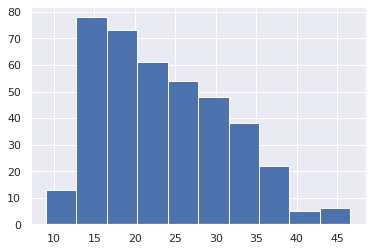

In [88]:
plt.hist(dataset['MPG']) #연비 히스토그램

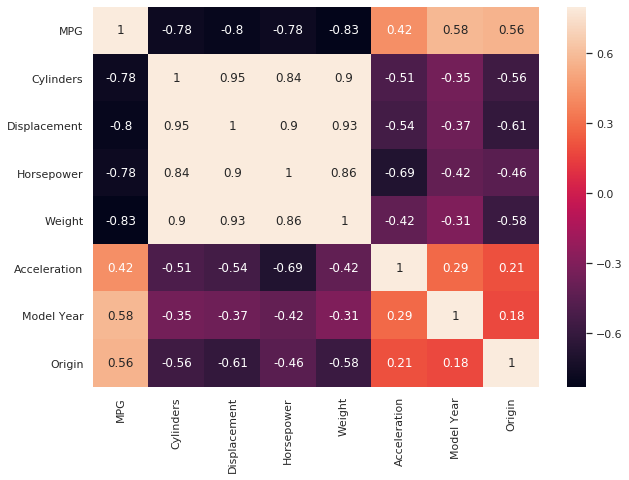

In [89]:
#상관관계 그래프
corrmat = dataset.corr()
f, ax = plt.subplots(figsize=(10, 7),facecolor='w') # 도화지 크기 설정
sns.heatmap(corrmat, vmax=.8, annot=True)

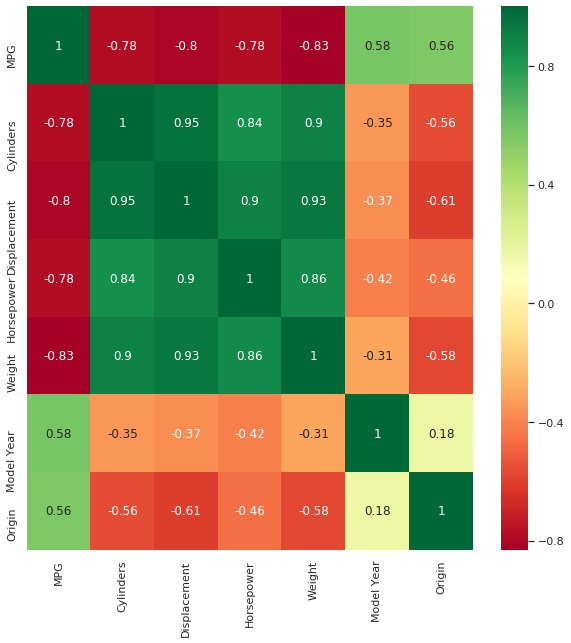

In [90]:
# 연비와 상관관계가 높은 feature만 뽑아보자.
corrmat = dataset.corr()
top_corr_features = corrmat.index[abs(corrmat["MPG"])>0.5]
plt.figure(figsize=(10,10),facecolor='w')
g = sns.heatmap(dataset[top_corr_features].corr(),annot=True,cmap="RdYlGn")

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


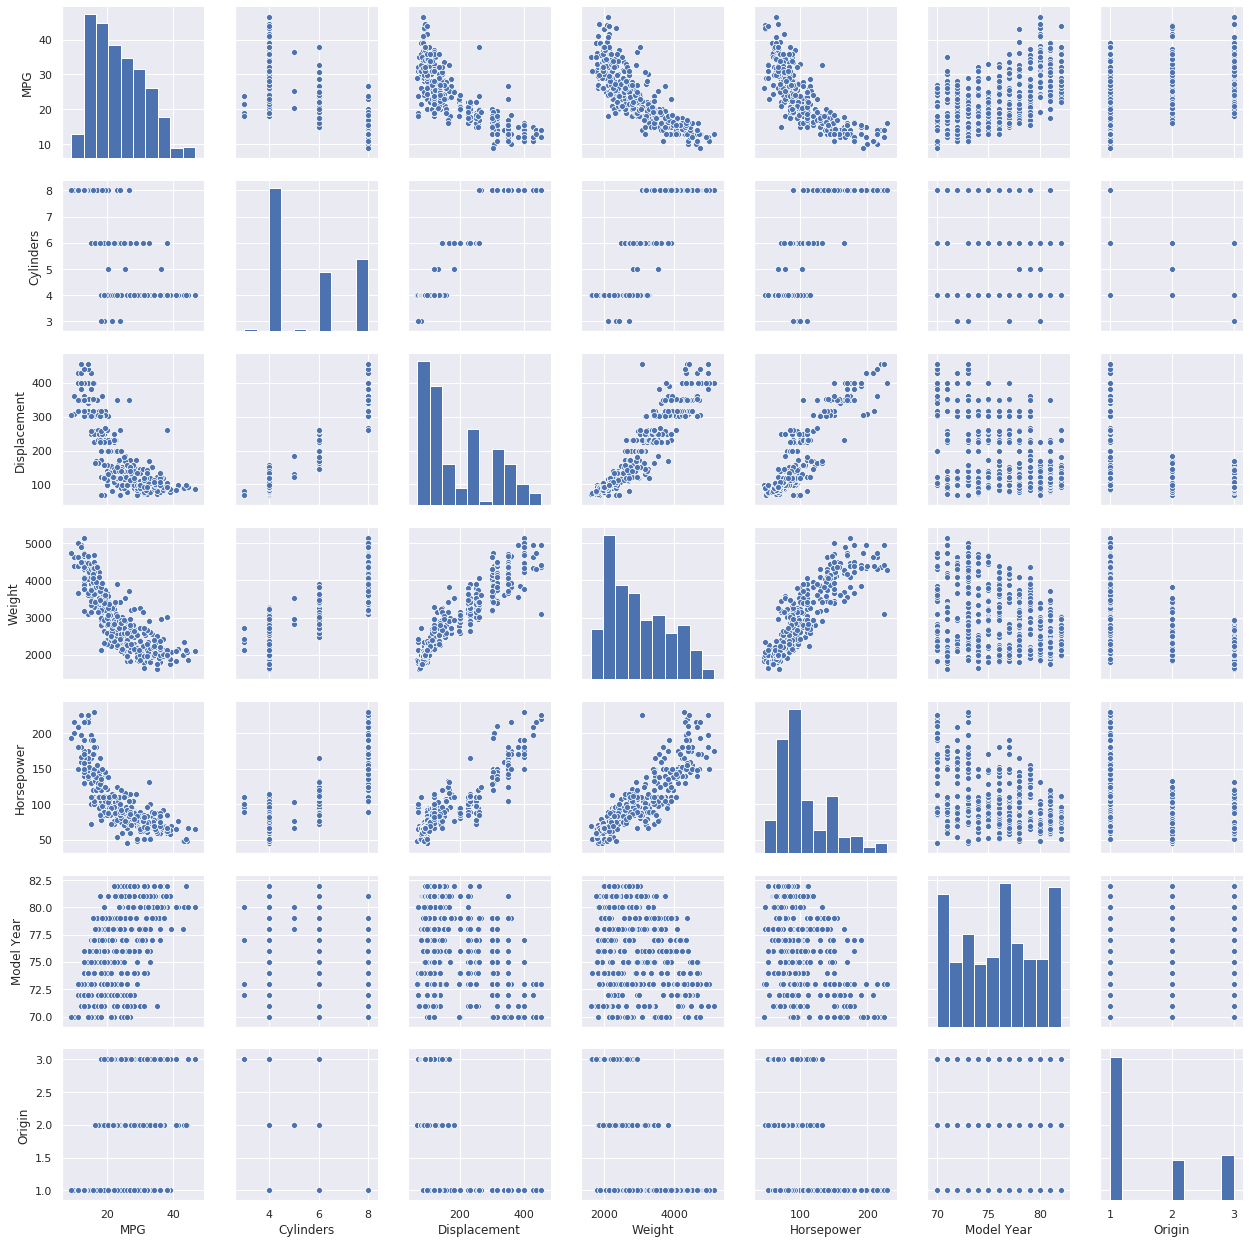

In [91]:
#산점도 행렬 출력
sns.set()
cols = ['MPG', 'Cylinders', 'Displacement', 'Weight', 'Horsepower', 'Model Year', 'Origin']
sns.pairplot(dataset[cols], size = 2.5)
plt.show()

## dataset 분할
- trainset과 testset 데이터로 분할을 시키자.

In [0]:
from sklearn.model_selection import train_test_split

In [93]:
#컬럼 확인
dataset.columns

Index(['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
       'Acceleration', 'Model Year', 'Origin'],
      dtype='object')

In [0]:
# Acceleration은 MPG와 상관관계가 낮으므로 제외를 시키자.
X_train,X_test,y_train,y_test = train_test_split(
    dataset[['Cylinders', 'Displacement', 'Horsepower', 'Weight'
    , 'Model Year', 'Origin']][:],dataset['MPG'][:],random_state=0
)

In [95]:
X_train

,Cylinders,Displacement,Horsepower,Weight,Model Year,Origin
254,6,200.0,85.0,2965.0,78,1
246,4,78.0,52.0,1985.0,78,3
282,4,140.0,88.0,2890.0,79,1
81,4,97.0,92.0,2288.0,72,3
347,4,85.0,65.0,1975.0,81,3
...,...,...,...,...,...,...
323,4,156.0,105.0,2800.0,80,1
192,6,250.0,105.0,3353.0,76,1
117,4,68.0,49.0,1867.0,73,2
47,6,250.0,100.0,3282.0,71,1


In [96]:
y_train

254    20.2
246    32.8
282    22.3
81     28.0
347    37.0
       ... 
323    27.9
192    22.0
117    29.0
47     19.0
172    25.0
Name: MPG, Length: 298, dtype: float64

In [97]:
# Null값 확인
print('-train NAN-\n',X_train.isnull().sum())
print()
print('-test NAN-\n',X_test.isnull().sum())

-train NAN-
 Cylinders       0
Displacement    0
Horsepower      5
Weight          0
Model Year      0
Origin          0
dtype: int64

-test NAN-
 Cylinders       0
Displacement    0
Horsepower      1
Weight          0
Model Year      0
Origin          0
dtype: int64


분할이 잘 되었음. numpy 배열 분할의 경우, 슬라이싱만을 사용해서 데이터셋 분할을 쉽게 할 수 있지만, 데이터 셋이 데이트프레임으로 되어있을 경우, 컬럼명을 꼭 사용해야하는 귀찮음이 있다.

______

# Data Preprocessing (데이터 전처리)
- 데이터 분석에서 가장 중요한 요소임. 데이터를 가져와 예측,분류를 하는 모델링까지 만드는 과정중에서 가장 시간이 오래 투여된다. 모델링을 할 때, 모델 자체에서 하이퍼 파라미터를 수정하면서 모델의 성능을 더 좋게 만들 수 있지만, 가장 근본적인 것은 데이터를 어떻게 전처리하고, 인코딩, 라벨링 하냐에 따라 모델의 성능의 차이를 좌우한다.

In [0]:
# train 셋과 test 셋을 한꺼번에 전처리 하기위해 리스트를 만들어 한번에 전처리를 하자.
train_test_data = [X_train,X_test]

## 1. Cylinders

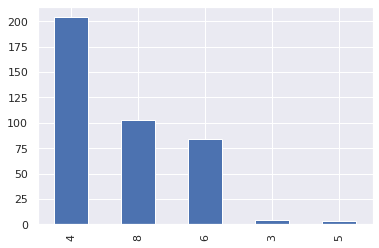

In [99]:
dataset['Cylinders'].value_counts().plot(kind='bar')

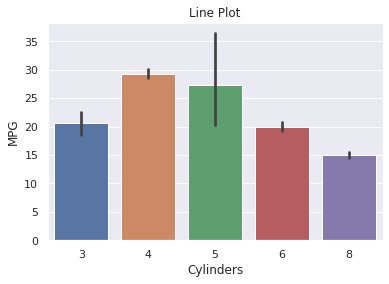

In [100]:
with sns.axes_style('darkgrid'):
  bars = sns.barplot(dataset.Cylinders,dataset.MPG)
  bars.set_title('Line Plot')
plt.show()

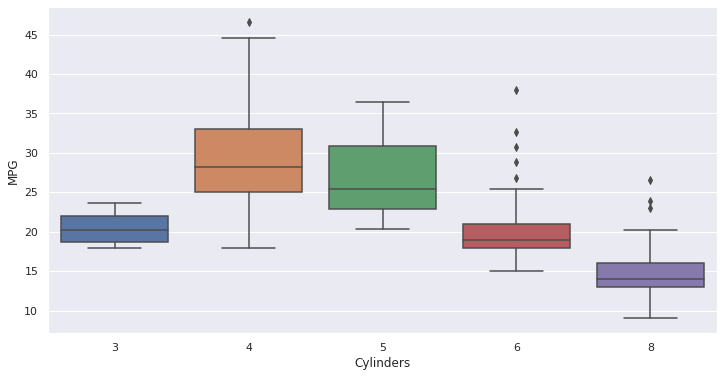

In [101]:
# sns.boxplot()

plt.figure(figsize=(12,6),facecolor='w')
plt.grid(True)

sns.boxplot(x='Cylinders',y='MPG',data=dataset)
plt.show()

이상치가 크게 많은 것 같지 않아서 처리를 하지 않아도 될 것 같음.

In [0]:
Cylinders_mapping ={3:0,4:1,5:2,6:3,8:4}

In [0]:
for data in train_test_data:
  data['Cylinders'] = data['Cylinders'].map(Cylinders_mapping)

In [104]:
X_train.head()

,Cylinders,Displacement,Horsepower,Weight,Model Year,Origin
254,3,200.0,85.0,2965.0,78,1
246,1,78.0,52.0,1985.0,78,3
282,1,140.0,88.0,2890.0,79,1
81,1,97.0,92.0,2288.0,72,3
347,1,85.0,65.0,1975.0,81,3


In [105]:
X_test.head()

,Cylinders,Displacement,Horsepower,Weight,Model Year,Origin
65,4,351.0,153.0,4129.0,72,1
132,1,140.0,75.0,2542.0,74,1
74,4,302.0,140.0,4294.0,72,1
78,1,120.0,87.0,2979.0,72,2
37,3,232.0,100.0,3288.0,71,1


## 2. Displacement

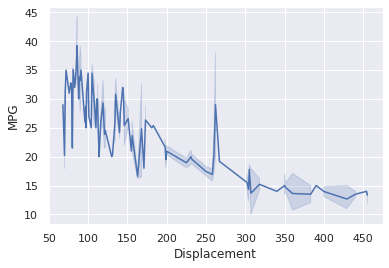

In [106]:
sns.lineplot(dataset.Displacement,dataset.MPG) # 50-200 :0,200-250: 1,250-275: 2,275-500: 3

In [0]:
for data in train_test_data:
  data.loc[data['Displacement']<=200,'Displacement']=0,
  data.loc[(data['Displacement']>200) & (data['Displacement']<=250),'Displacement']=1,
  data.loc[(data['Displacement']>250) & (data['Displacement']<=275),'Displacement']=2,
  data.loc[data['Displacement']>270,'Displacement']=3

In [108]:
X_train.head()

,Cylinders,Displacement,Horsepower,Weight,Model Year,Origin
254,3,0.0,85.0,2965.0,78,1
246,1,0.0,52.0,1985.0,78,3
282,1,0.0,88.0,2890.0,79,1
81,1,0.0,92.0,2288.0,72,3
347,1,0.0,65.0,1975.0,81,3


In [109]:
X_test.head()

,Cylinders,Displacement,Horsepower,Weight,Model Year,Origin
65,4,3.0,153.0,4129.0,72,1
132,1,0.0,75.0,2542.0,74,1
74,4,3.0,140.0,4294.0,72,1
78,1,0.0,87.0,2979.0,72,2
37,3,1.0,100.0,3288.0,71,1


## 3. Horsepower

In [110]:
X_train['Horsepower'].dtype

dtype('float64')

In [111]:
X_train['Horsepower'].isnull().sum()

5

### Null data prepocess (Null 값 처리)
- 마력은 자동차 Cylinders와 Weight와 상관관계가 높음

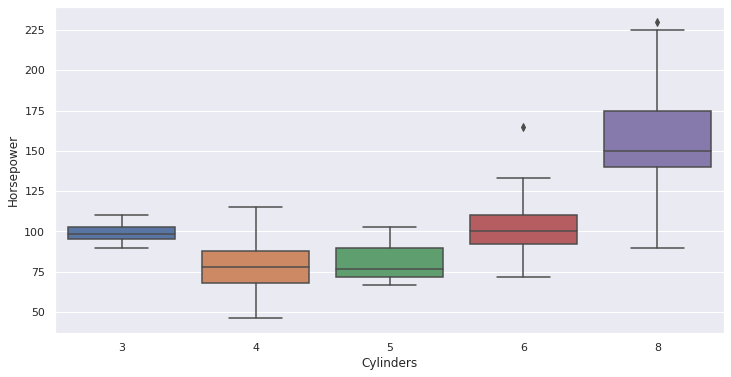

In [112]:
# sns.boxplot()

plt.figure(figsize=(12,6),facecolor='w')
plt.grid(True)

sns.boxplot(x='Cylinders',y='Horsepower',data=dataset)
plt.show()

-> 각 Cylinders 별로 Horespower의 평균 또는 중간값을 구해서 nan 값을 대체하면 될 것 같다.

In [113]:
X_train['Horsepower'].groupby(X_train['Cylinders']).median()

Cylinders
0     97.0
1     79.0
2     90.0
3    100.0
4    150.0
Name: Horsepower, dtype: float64

In [0]:
# fill missing Horsepower with median Horsepower for each Cylinders
X_train['Horsepower'].fillna(X_train.groupby('Cylinders')['Horsepower'].transform('median'),inplace=True)
X_test['Horsepower'].fillna(X_test.groupby('Cylinders')['Horsepower'].transform('median'),inplace=True)

### label encoding

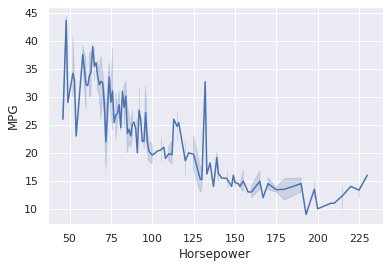

In [115]:
sns.lineplot(dataset.Horsepower,dataset.MPG) # 마력이 증가할수록 연비가 떨어짐

In [0]:
for data in train_test_data:
  data.loc[data['Horsepower']<=100,'Horsepower']=0,
  data.loc[(data['Horsepower']>100) & (data['Horsepower']<=150),'Horsepower']=1,
  data.loc[(data['Horsepower']>150) & (data['Horsepower']<=200),'Horsepower']=2,
  data.loc[data['Horsepower']>200,'Horsepower']=3

In [117]:
X_train.head()

,Cylinders,Displacement,Horsepower,Weight,Model Year,Origin
254,3,0.0,0.0,2965.0,78,1
246,1,0.0,0.0,1985.0,78,3
282,1,0.0,0.0,2890.0,79,1
81,1,0.0,0.0,2288.0,72,3
347,1,0.0,0.0,1975.0,81,3


In [118]:
X_test.head()

,Cylinders,Displacement,Horsepower,Weight,Model Year,Origin
65,4,3.0,2.0,4129.0,72,1
132,1,0.0,0.0,2542.0,74,1
74,4,3.0,1.0,4294.0,72,1
78,1,0.0,0.0,2979.0,72,2
37,3,1.0,0.0,3288.0,71,1


## 4. Weight


### labeling

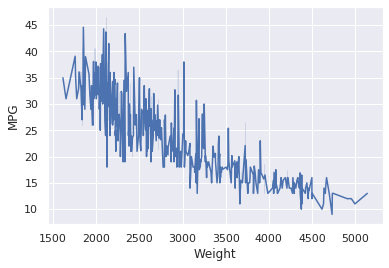

In [119]:
sns.lineplot(dataset.Weight,dataset.MPG) # 마력이 증가할수록 연비가 떨어짐

In [0]:
for data in train_test_data:
  data.loc[data['Weight']<=2500,'Weight']=0,
  data.loc[(data['Weight']>2500) & (data['Weight']<=3500),'Weight']=1,
  data.loc[(data['Weight']>3500) & (data['Weight']<=4500),'Weight']=2,
  data.loc[data['Weight']>4500,'Weight']=3

In [121]:
X_train.head()

,Cylinders,Displacement,Horsepower,Weight,Model Year,Origin
254,3,0.0,0.0,1.0,78,1
246,1,0.0,0.0,0.0,78,3
282,1,0.0,0.0,1.0,79,1
81,1,0.0,0.0,0.0,72,3
347,1,0.0,0.0,0.0,81,3


In [122]:
X_test.head()

,Cylinders,Displacement,Horsepower,Weight,Model Year,Origin
65,4,3.0,2.0,2.0,72,1
132,1,0.0,0.0,1.0,74,1
74,4,3.0,1.0,2.0,72,1
78,1,0.0,0.0,1.0,72,2
37,3,1.0,0.0,1.0,71,1


## 5. Model Year

In [123]:
dataset['Model Year'].value_counts()

73    40
78    36
76    34
82    31
75    30
81    29
80    29
79    29
70    29
77    28
72    28
71    28
74    27
Name: Model Year, dtype: int64

labeling

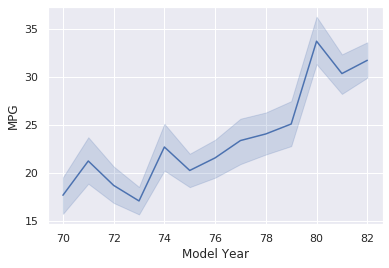

In [124]:
sns.lineplot(dataset['Model Year'],dataset.MPG)

In [0]:
for data in train_test_data:
  data.loc[data['Model Year']<=74,'Model Year']=0,
  data.loc[(data['Model Year']>74) & (data['Model Year']<=79),'Model Year']=1,
  data.loc[data['Model Year']>79,'Model Year']=3

In [126]:
X_train.head()

,Cylinders,Displacement,Horsepower,Weight,Model Year,Origin
254,3,0.0,0.0,1.0,1,1
246,1,0.0,0.0,0.0,1,3
282,1,0.0,0.0,1.0,1,1
81,1,0.0,0.0,0.0,0,3
347,1,0.0,0.0,0.0,3,3


In [127]:
X_test.head()

,Cylinders,Displacement,Horsepower,Weight,Model Year,Origin
65,4,3.0,2.0,2.0,0,1
132,1,0.0,0.0,1.0,0,1
74,4,3.0,1.0,2.0,0,1
78,1,0.0,0.0,1.0,0,2
37,3,1.0,0.0,1.0,0,1


# 5. Origin

In [128]:
dataset['Origin'].value_counts() #따로 설정하지 않아도 될 것 같다.

1    249
3     79
2     70
Name: Origin, dtype: int64

# Modeling
- Using Tensorflow

In [129]:
x_data=np.array(X_train)
x_data.shape

(298, 6)

In [130]:
y_data=np.array(y_train)
y_data=y_data.reshape(298,1)
y_data.shape

(298, 1)

In [131]:
x_test = np.array(X_test)
x_test.shape

(100, 6)

In [132]:
y_test = np.array(y_test)
y_test = y_test.reshape(100,1)
y_test.shape

(100, 1)

---

In [0]:
X = tf.placeholder(tf.float32,shape=[None,6])
Y = tf.placeholder(tf.float32,shape=[None,1])

W = tf.Variable(tf.random_normal([6,1]),name='weight')
b = tf.Variable(tf.random_normal([1]),name='bias')

In [0]:
# Hypothesis
hypothesis = tf.matmul(X,W)+b

#Simple cost/loss function
cost = tf.reduce_mean(tf.square(hypothesis -Y))
#Minimize
optimizer =tf.train.GradientDescentOptimizer(learning_rate =1e-5)
train = optimizer.minimize(cost)

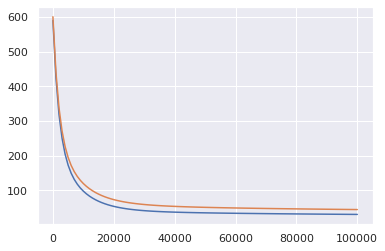

In [164]:
#launch the graph in a session
sess =tf.Session()
#Initializes global variables in the graph
sess.run(tf.global_variables_initializer())

t1=[]
t2=[]
v1=[]
for step in range(100001):
  cost_train,hy_train,_ =sess.run(
      [cost,hypothesis,train],feed_dict={X:x_data,Y:y_data})
  cost_val,hy_val=sess.run(
      [cost,hypothesis],feed_dict={X:x_test,Y:y_test})
  if step %1000 ==0:
   #print(step,'cost:',cost_val,'\nPrediction:\n',hy_val)
    t1.append(step)
    t2.append(cost_train)
    v1.append(cost_val)

plt.plot(t1,t2,label='w,k')
plt.plot(t1,v1,label='w,k')
plt.show()

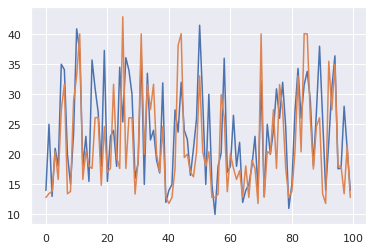

In [161]:
x_graph=[]
for i in range(len(y_test)):
  x_graph.append(i)

plt.plot(x_graph,y_test,label='w,k')
plt.plot(x_graph,np.array(hy_val).reshape(100,1),label='w,k')
plt.show()


학습 횟수가 증가할수록 validation_data의 loss도 같이 감소하는 것을 볼 수 있다. 즉, 학습 횟수가 1만번 이상 증가하게 되면 자동차 연비를 예측하는데 유용한 모델이 될 수 있는 것 같다고 판단했다. 또한 회귀선을 통한 x_val 과 y_test의 차이의 추세 그래프가 비슷한 것을 보아 학습이 제대로 됐고 과적합이 없는 것으로 판단 됐음.

### 전처리, 모델링 과정을 하면서 느낀점
- 종속변수와 상관관계가 높은 feature을 선별하여 그것을 모두 라벨링 주어 학습을 시켰다. 회귀분석에서 연속형 변수를 범주화를 시키면 각 변수가 가지고 있는 특징을 잃어버리게 되지만 종속변수와의 선형관계를 통해 범주화를 시킨 것이 학습하는 데 크게 도움이 된 것 같다
.